This notebook was done and ran in Google Colaboratory (Plan: Free of charge) with RAM: 12.68GB and Disk: 107.72GB, Python 3 Google Compute Engine Backend.

###**Set working environment** 

In [1]:
# Install Spark NLP from PyPI
!pip install -q spark-nlp==4.0.1 pyspark==3.3.0

     |████████████████████████████████| 531 kB 2.9 MB/s 
     |████████████████████████████████| 281.3 MB 45 kB/s 
     |████████████████████████████████| 199 kB 56.0 MB/s 


In [2]:
import os
import sys

import sparknlp

from sparknlp.base import *
from sparknlp.common import *
from sparknlp.annotator import *

from pyspark.sql import functions as func
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession

import numpy as np
import pandas as pd

# https://github.com/JohnSnowLabs/spark-nlp
# Start spark session
spark=sparknlp.start()

print("Spark NLP version: ", sparknlp.version())
print("Apache Spark version: ", spark.version)

spark

Spark NLP version:  4.0.1
Apache Spark version:  3.3.0


In [3]:
# https://stackoverflow.com/questions/36786722/how-to-display-full-output-in-jupyter-not-only-last-result
# Display full output in output cell, not only last result
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [4]:
# Import libraries
import pandas as pd

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.artist as artists
import plotly.graph_objects as go

# https://www.coursera.org/learn/ds/lecture/mjCxm/plotting-with-apachespark-and-pythons-matplotlib (at  04:47)
# Display all plots created by matplotlib as images under the cell 
%matplotlib inline

import time

In [5]:
# https://www.kaggle.com/questions-and-answers/118932
# Max rows and columns of pandas dataframe 
pd.options.display.max_rows,pd.options.display.max_columns

# https://thispointer.com/python-pandas-how-to-display-full-dataframe-i-e-print-all-rows-columns-without-truncation/
# Print all the contents of a pandas dataframe
pd.set_option('display.max_rows', None) # Print unlimited number of rows by setting to None, default is 10
pd.set_option('display.max_columns', None) # Do not truncate columns to display all of them by setting to None
pd.set_option('display.width', None) # Auto-detect the width of dataframe to display all columns in single line by setting to None
pd.set_option('display.max_colwidth', None) # Auto detect the max size of column and print contents of that column without truncated the contents

(60, 20)

### **Read source data<sup> [1](https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews) </sup>**

In [6]:
!wget https://raw.githubusercontent.com/wongkhoon/Coursera/main/Advanced%20Data%20Science%20with%20IBM/Advanced%20Data%20Science%20Capstone/Womens%20Clothing%20E-Commerce%20Reviews.csv
raw_sdf=spark.read.csv("Womens Clothing E-Commerce Reviews.csv",header=True,escape='"',multiLine=True,inferSchema=True).drop('_c0')

--2022-08-05 17:56:20--  https://raw.githubusercontent.com/wongkhoon/Coursera/main/Advanced%20Data%20Science%20with%20IBM/Advanced%20Data%20Science%20Capstone/Womens%20Clothing%20E-Commerce%20Reviews.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8483448 (8.1M) [text/plain]
Saving to: ‘Womens Clothing E-Commerce Reviews.csv’

Womens Clothing E-C 100%[===================>]   8.09M  --.-KB/s    in 0.1s    

2022-08-05 17:56:20 (74.5 MB/s) - ‘Womens Clothing E-Commerce Reviews.csv’ saved [8483448/8483448]



### **Perform random sampling with replacement**
Reduce the original data size by random sampling with replacement to address the runtime crashes due to compute usage limitation for training from the following environments:
*   IBM Watson Studio Plan Lite (Free)
*   Google Colaboratory 12.68GB RAM allocation



In [7]:
# https://stackoverflow.com/questions/8924173/how-to-print-bold-text-in-python
start = "\033[1m" # Bold text
end = "\033[0;0m" # Reset 

print(start+'---- ORIGINAL DATA ----'+end,'\n')

print(start+'Data shape:'+end,'Total of ' + str(raw_sdf.count()),'entries,',len(raw_sdf.columns),'data columns','\n')

raw_sdf.groupBy("Recommended IND") \
  .count() \
  .withColumn('proportion',(func.col('count')/raw_sdf.count())*100) \
  .show()

print(start+'---- Post random sampling without replacement ----'+end,'\n')
sampled_sdf=raw_sdf.sample(withReplacement=False, fraction=0.2544, seed=42)
print(start+'Data shape:'+end,'Total of ' + str(sampled_sdf.count()),'entries,',len(sampled_sdf.columns),'data columns','\n')

sampled_sdf.groupBy("Recommended IND") \
  .count() \
  .withColumn('proportion',(func.col('count')/sampled_sdf.count())*100) \
  .show()


---- ORIGINAL DATA ---- 

Data shape: Total of 23486 entries, 10 data columns 

+---------------+-----+------------------+
|Recommended IND|count|        proportion|
+---------------+-----+------------------+
|              1|19314| 82.23622583666865|
|              0| 4172|17.763774163331348|
+---------------+-----+------------------+

---- Post random sampling without replacement ---- 

Data shape: Total of 6000 entries, 10 data columns 

+---------------+-----+------------------+
|Recommended IND|count|        proportion|
+---------------+-----+------------------+
|              1| 4929|             82.15|
|              0| 1071|17.849999999999998|
+---------------+-----+------------------+



### **Post-sampling data exploration**

In [8]:
# https://stackoverflow.com/questions/8924173/how-to-print-bold-text-in-python
start = "\033[1m" # Bold text
end = "\033[0;0m" # Reset 

print(start+'---- POST-SAMPLING DATA ----'+end,'\n')

#print(start+'Data shape:'+end,'Total of ' + str(sampled_sdf.shape[0]),'entries,',sampled_sdf.shape[1],'data columns','\n')
print(start+'Data shape:'+end,'Total of ' + str(sampled_sdf.count()),'entries,',len(sampled_sdf.columns),'data columns','\n')

print(start+'Schema of dataframe:'+end)
sampled_sdf.printSchema()

print('\n'+start+'First three entries:'+end)
sampled_sdf.show(3,truncate=False) 

'''
print('\n'+start+'Last three entries:'+end)
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import desc
sampled_sdf= sampled_sdf.withColumn("index", monotonically_increasing_id())
sampled_sdf.orderBy(desc("index")).drop("index").show(3)
'''

# https://sparkbyexamples.com/pyspark/pyspark-count-of-non-null-nan-values-in-dataframe/#:~:text=Solution%3A%20In%20order%20to%20find,isnan(df.name)%20.
# Count of non-null by ignoring null literal values
from pyspark.sql.functions import col,when,count
print(start+'\n\nNumber of available data of all columns:',end)
sampled_sdf.select([count(when(~col(c).contains('None') | \
                           ~col(c).contains('NULL') | \
                           (col(c) != '') | \
                           ~col(c).isNull() | \
                           col(c).isNotNull(), c 
                           )).alias(c)
                           for c in sampled_sdf.columns]).show(truncate=False)

# Find count for empty, None, Null, Nan with string literals
from pyspark.sql.functions import col,isnan,when,count
print(start+'Number of unavailable data of all columns:',end)
sampled_sdf.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                           for c in sampled_sdf.columns]).show(truncate=False)

# https://stackoverflow.com/questions/53763417/number-of-unique-elements-in-all-columns-of-a-pyspark-dataframe
from pyspark.sql.functions import countDistinct
print(start+'Distinct value count of all columns:',end)
expression = [countDistinct(c).alias(c) for c in sampled_sdf.columns]
sampled_sdf.select(*expression).show(truncate=False)

# https://stackoverflow.com/questions/44066635/selecting-only-numeric-string-columns-names-from-a-spark-df-in-pyspark
from pyspark.sql.functions import desc
print(start,'Number of distinct values in a column',end)
for column in [item[0] for item in sampled_sdf.dtypes if item[1].startswith('string')]:
  sampled_sdf.groupBy(column).count().sort(desc('count')).show(truncate=False)

---- POST-SAMPLING DATA ---- 

Data shape: Total of 6000 entries, 10 data columns 

Schema of dataframe:
root
 |-- Clothing ID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Review Text: string (nullable = true)
 |-- Rating: integer (nullable = true)
 |-- Recommended IND: integer (nullable = true)
 |-- Positive Feedback Count: integer (nullable = true)
 |-- Division Name: string (nullable = true)
 |-- Department Name: string (nullable = true)
 |-- Class Name: string (nullable = true)


First three entries:
+-----------+---+-------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

'\nprint(\'\n\'+start+\'Last three entries:\'+end)\nfrom pyspark.sql.functions import monotonically_increasing_id\nfrom pyspark.sql.functions import desc\nsampled_sdf= sampled_sdf.withColumn("index", monotonically_increasing_id())\nsampled_sdf.orderBy(desc("index")).drop("index").show(3)\n'



Number of available data of all columns: 
+-----------+----+-----+-----------+------+---------------+-----------------------+-------------+---------------+----------+
|Clothing ID|Age |Title|Review Text|Rating|Recommended IND|Positive Feedback Count|Division Name|Department Name|Class Name|
+-----------+----+-----+-----------+------+---------------+-----------------------+-------------+---------------+----------+
|6000       |6000|5057 |5781       |6000  |6000           |6000                   |5998         |5998           |5998      |
+-----------+----+-----+-----------+------+---------------+-----------------------+-------------+---------------+----------+

Number of unavailable data of all columns: 
+-----------+---+-----+-----------+------+---------------+-----------------------+-------------+---------------+----------+
|Clothing ID|Age|Title|Review Text|Rating|Recommended IND|Positive Feedback Count|Division Name|Department Name|Class Name|
+-----------+---+-----+-----------+---

#### **Check duplicates**

In [9]:
# Duplicate entries dataframe
dup_sdf=sampled_sdf.groupBy(sampled_sdf.columns).count().filter("count > 1").orderBy(["Clothing ID", "Age"], ascending=[1, 1])

# Count duplicate in dataFrame
print(start+'Total number of duplicates from the sampled Spark dataframe based on all the 10 data columns:'+end,str(dup_sdf.drop('count').count()),'entries\n')

# https://www.geeksforgeeks.org/find-duplicate-rows-in-a-dataframe-based-on-all-or-selected-columns/
# Selecting duplicate rows except first occurrence based on all columns
print(start+'Duplicates to be removed:'+end)
dup_sdf.drop('count').show(50,truncate=False)

# Drop the duplicate entries from the sampled dataframe
nodup_sdf = sampled_sdf.dropDuplicates()
print(start+'After removing duplicates:'+end,'Total of', nodup_sdf.count(),'entries,',len(nodup_sdf.columns),'data columns','\n')

Total number of duplicates from the sampled Spark dataframe based on all the 10 data columns: 2 entries

Duplicates to be removed:
+-----------+---+-----+-----------+------+---------------+-----------------------+--------------+---------------+----------+
|Clothing ID|Age|Title|Review Text|Rating|Recommended IND|Positive Feedback Count|Division Name |Department Name|Class Name|
+-----------+---+-----+-----------+------+---------------+-----------------------+--------------+---------------+----------+
|861        |34 |null |null       |5     |1              |0                      |General       |Tops           |Knits     |
|862        |35 |null |null       |5     |1              |0                      |General Petite|Tops           |Knits     |
+-----------+---+-----+-----------+------+---------------+-----------------------+--------------+---------------+----------+

After removing duplicates: Total of 5998 entries, 10 data columns 



#### **Feature engineering**
- Pretend text and combine string columns by following [here](https://mccormickml.com/2021/06/29/combining-categorical-numerical-features-with-bert/#s3-bert-with-all-features):
<br> This item comes from {Department Name} department and division is {Division
Name}, and is classified under {Class Name}. {Title}. {Review Text}, where empty string information on division, department and class was imputed with "unknown". 
<br> 

In [10]:
# https://spark.apache.org/docs/latest/api/python/user_guide/pandas_on_spark/pandas_pyspark.html

import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

# Create pandas-on-Spark DataFrame from Spark DataFrame
nodup_psdf=nodup_sdf.pandas_api()        

combined_psdf=nodup_psdf.copy()

# Reference https://mccormickml.com/2021/06/29/combining-categorical-numerical-features-with-bert/
# Combine string columns into one single text feature
# Prepend the text and replace missing department, division or class by 'unknown'
combined_psdf["text1"]="This item comes from " + combined_psdf["Department Name"].fillna("unknown") + " department" + \
                       " and division is " + combined_psdf["Division Name"].fillna(" unknown") + \
                       ", and is classified under " + combined_psdf["Class Name"].fillna(" unknown") + ". " + \
                       "There are " + combined_psdf["Positive Feedback Count"].astype(str) + " customers who found this review positive. " + \
                       "I am " + combined_psdf["Age"].astype(str) + " years old. " + \
                       "I rate this item " + combined_psdf["Rating"].astype(str) + " out of 5 stars." 
                      
combined_psdf['text2']=(combined_psdf["Title"].where(combined_psdf["Title"].str.contains('[.?!]$'),combined_psdf["Title"] + '.')).fillna("")+' ' + \
                       (combined_psdf["Review Text"].where(combined_psdf["Review Text"].str.contains('[.?!]$'),combined_psdf["Review Text"] + '.')).fillna("")

combined_psdf['text']=combined_psdf['text1'].fillna("")+' ' +combined_psdf['text2'].fillna("")

In [11]:
# Drop unnecessary columns 

# Convert to pandas-on-spark dataframe
final_psdf=combined_psdf.drop(['Clothing ID','text1','text2'],axis=1).copy()
final_psdf.reset_index(drop=True,inplace=True)

# Convert to Spark dataframe from pandas-on-Spark DataFrame
final_sdf=final_psdf.to_spark()

/usr/local/lib/python3.7/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [12]:
# Take a look at the dataframe
print(start+'Take a look at the pandas-on-Spark dataframe:'+end)
final_psdf.head(2)

print(start+'Take a look at the Spark dataframe:'+end)
final_sdf.show(2,truncate=30)

Take a look at the pandas-on-Spark dataframe:


,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,text
0,39,Stinky sweater!,"Yikes! quite a smell off of this one- like wet/hot wool. the color was beautiful, but the sweater is enormous! strange fit under the arms as well. this one went back the same day.",1,0,0,General,Tops,Sweaters,"This item comes from Tops department and division is General, and is classified under Sweaters. There are 0 customers who found this review positive. I am 39 years old. I rate this item 1 out of 5 stars. Stinky sweater! Yikes! quite a smell off of this one- like wet/hot wool. the color was beautiful, but the sweater is enormous! strange fit under the arms as well. this one went back the same day."
1,21,None,"Great fabric but unfortunately it did not look good on me. maybe on a tall person, i'm only 5'4"". really wanted to like this...",3,0,0,General Petite,Bottoms,Pants,"This item comes from Bottoms department and division is General Petite, and is classified under Pants. There are 0 customers who found this review positive. I am 21 years old. I rate this item 3 out of 5 stars. Great fabric but unfortunately it did not look good on me. maybe on a tall person, i'm only 5'4"". really wanted to like this..."


Take a look at the Spark dataframe:
+---+---------------+------------------------------+------+---------------+-----------------------+--------------+---------------+----------+------------------------------+
|Age|          Title|                   Review Text|Rating|Recommended IND|Positive Feedback Count| Division Name|Department Name|Class Name|                          text|
+---+---------------+------------------------------+------+---------------+-----------------------+--------------+---------------+----------+------------------------------+
| 39|Stinky sweater!|Yikes!  quite a smell off o...|     1|              0|                      0|       General|           Tops|  Sweaters|This item comes from Tops d...|
| 21|           null|Great fabric but unfortunat...|     3|              0|                      0|General Petite|        Bottoms|     Pants|This item comes from Bottom...|
+---+---------------+------------------------------+------+---------------+-----------------------+

In [13]:
# https://sparkbyexamples.com/pyspark/pyspark-count-of-non-null-nan-values-in-dataframe/#:~:text=Solution%3A%20In%20order%20to%20find,isnan(df.name)%20.
# Count of non-null by ignoring null literal values
from pyspark.sql.functions import col,when,count

print(start+'\nNumber of available data of all columns:',end)
final_sdf.select([count(when(~col(c).contains('None') | \
                           ~col(c).contains('NULL') | \
                           (col(c) != '') | \
                           ~col(c).isNull() | \
                           col(c).isNotNull(), c 
                           )).alias(c)
                           for c in final_sdf.columns]).show(truncate=False)

# Find count for empty, None, Null, Nan with string literals
from pyspark.sql.functions import col,isnan,when,count
print(start+'Number of unavailable data of all columns:',end)
final_sdf.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                           for c in final_sdf.columns]).show(truncate=False)


Number of available data of all columns: 
+----+-----+-----------+------+---------------+-----------------------+-------------+---------------+----------+----+
|Age |Title|Review Text|Rating|Recommended IND|Positive Feedback Count|Division Name|Department Name|Class Name|text|
+----+-----+-----------+------+---------------+-----------------------+-------------+---------------+----------+----+
|5998|5057 |5781       |5998  |5998           |5998                   |5996         |5996           |5996      |5998|
+----+-----+-----------+------+---------------+-----------------------+-------------+---------------+----------+----+

Number of unavailable data of all columns: 
+---+-----+-----------+------+---------------+-----------------------+-------------+---------------+----------+----+
|Age|Title|Review Text|Rating|Recommended IND|Positive Feedback Count|Division Name|Department Name|Class Name|text|
+---+-----+-----------+------+---------------+-----------------------+-------------+----

#### **Class imbalance**

In [14]:
psdf = final_psdf['Recommended IND'].value_counts()
psdf = psdf.reset_index()
fig = psdf.plot.pie(
    y="Recommended IND",
    names=['Recommended (n=' + str(psdf['Recommended IND'][0]) +')', 'Not recommended (n=' + str(psdf['Recommended IND'][1]) +')']
)
fig.update_layout(
    title_text='<b>Pie chart by recommendation</b>',
    title_font=dict(size=16),
    title_x=0.45,
)

# Clear dataframe from memory
del psdf

Text(0.5, 1.0, 'Class imbalance')

Text(0, 0.5, 'Count')

1071 -0.4 0.8
4927 0.6 0.8


Below, we see that about 82.1% of the item in this dataset are recommended, while 17.9% are not recommended.
That is, there are about 5 times recommended items more than not recommeded items.
This means we can get an accuracy of about 82.1% without any model - just declare that item is not recommended.
We will calculate the ROC-AUC and Precision-recall score to evaluate performance of our model, and also look at the other evaluation metrics e.g. accuracy, precision, recall and F1-score as well
to see if we improved upon the 82.1% accuracy.


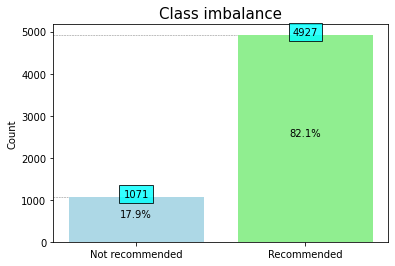

In [15]:
from pyspark.sql.functions import count,col
from pyspark.sql.types import StringType

sdf=final_sdf.withColumn("Recommended IND" , col("Recommended IND").cast(StringType())) \
          .replace(['0', '1'], ['Not recommended', 'Recommended']) \
          .select('Recommended IND') \
          .groupby('Recommended IND') \
          .agg(count('Recommended IND').alias('count'))
lst=sdf.collect()

labels=[row['Recommended IND'] for row in lst]
counts=[row['count'] for row in lst]

fig, ax = plt.subplots()

ax.set_title('Class imbalance',fontsize=15)

bar_plot=plt.bar(labels,counts,color=['lightblue', 'lightgreen'])
plt.ylabel('Count')

plt.axhline(counts[0],xmax=0.045, color='grey', linestyle='dashed', linewidth=0.5)
plt.axhline(counts[1],xmax=0.55,color='grey', linestyle='dashed', linewidth=0.5)

# https://pythonguides.com/matplotlib-bar-chart-labels/
def countlabel(labels,counts):
    for i in range(len(labels)):
        plt.text(i,counts[i],counts[i], ha = 'center',
                 bbox = dict(facecolor = 'cyan', alpha =0.8))
countlabel(labels,counts) 

# https://dphi.tech/notebooks/1039/components/modebar
# https://moonbooks.org/Articles/How-to-add-text-on-a-bar-with-matplotlib-/
# https://www.geeksforgeeks.org/display-percentage-above-bar-chart-in-matplotlib/
# https://tutorial.eyehunts.com/python/how-to-display-2-decimal-places-in-python-example-code/#:~:text=Use%20str.,decimal%20places%20in%20the%20console.

def pctlabel(rects):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2.,
                0.5*height,
                str("{:.1f}".format(100*counts[idx]/(counts[0]+counts[1])))+'%',
                ha='center', va='bottom', rotation=0)
        print(rect.get_height(),rect.get_x(), rect.get_width())
                
pctlabel(bar_plot)

# Coursera\PROF CERT - IBM ML\5\Wk 2\Keras Demo (Activity)\05d_LAB_Keras_Intro.ipynb
# https://docs.python.org/3/tutorial/inputoutput.html

print("\n\n"+f"Below, we see that about {final_psdf['Recommended IND'].value_counts(normalize=True)[1]*100:.1f}% of the item in this dataset are recommended, while {final_psdf['Recommended IND'].value_counts(normalize=True)[0]*100:.1f}% are not recommended."\
      +"\nThat is, there are about 5 times recommended items more than not recommeded items."
      +f"\nThis means we can get an accuracy of about {final_psdf['Recommended IND'].value_counts(normalize=True)[1]*100:.1f}% without any model - just declare that item is not recommended."\
      +"\nWe will calculate the ROC-AUC and Precision-recall score to evaluate performance of our model, and also look at the other evaluation metrics e.g. accuracy, precision, recall and F1-score as well"\
      +f"\nto see if we improved upon the {final_psdf['Recommended IND'].value_counts(normalize=True)[1]*100:.1f}% accuracy.")

del sdf,lst

#### **Distribution plots of numerical features**

/usr/local/lib/python3.7/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning:

`to_list` loads all data into the driver's memory. It should only be used if the resulting list is expected to be small.

/usr/local/lib/python3.7/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning:

`to_list` loads all data into the driver's memory. It should only be used if the resulting list is expected to be small.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



[Text(0, 0, 'Not recommended'), Text(0, 0, 'Recommended')]

Text(0, 0.5, 'Age of reviewers (years)')

/usr/local/lib/python3.7/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning:

`to_list` loads all data into the driver's memory. It should only be used if the resulting list is expected to be small.

/usr/local/lib/python3.7/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning:

`to_list` loads all data into the driver's memory. It should only be used if the resulting list is expected to be small.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



[Text(0, 0, 'Not recommended'), Text(0, 0, 'Recommended')]

Text(0, 0.5, 'Positive feedback count')

/usr/local/lib/python3.7/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning:

`to_list` loads all data into the driver's memory. It should only be used if the resulting list is expected to be small.

/usr/local/lib/python3.7/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning:

`to_list` loads all data into the driver's memory. It should only be used if the resulting list is expected to be small.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



[Text(0, 0, 'Not recommended'), Text(0, 0, 'Recommended')]

Text(0, 0.5, 'Rating (Worst=1, 2, 3, 4, Best=5)')

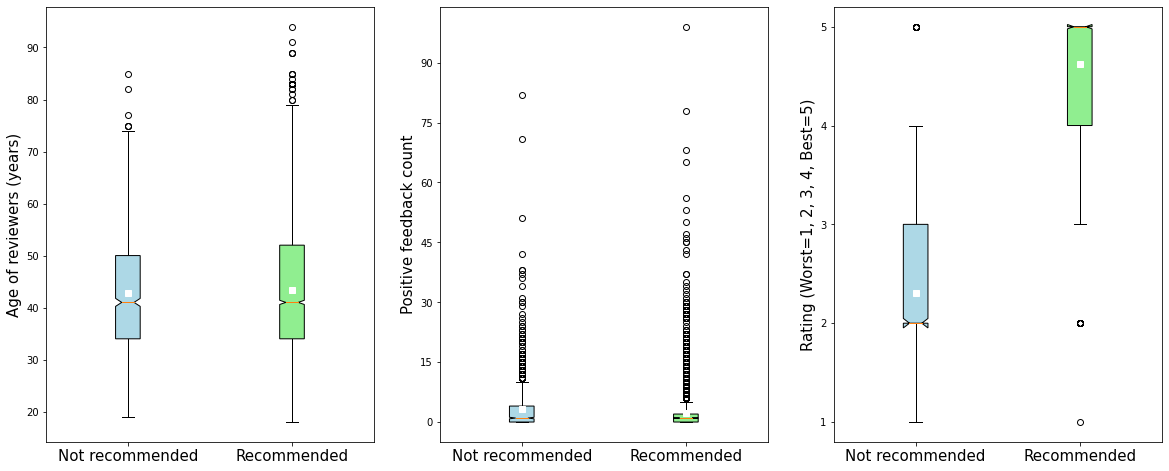



Summary statistics:



n    Mean      SD Min      Q1  Median      Q3 Max
Numerical features         Recommendation\ngroup                                                       
Age of reviewers           Not recommended        1,071  42.744  11.642  19  34.000  41.000  50.000  85
                           Recommended            4,927  43.413  12.408  18  34.000  41.000  52.000  94
                           Total                  5,998  43.294  12.276  18  34.000  41.000  52.000  94
Positive review counts     Not recommended        1,071   3.334   6.441   0   0.000   1.000   4.000  82
                           Recommended            4,927   2.290   5.053   0   0.000   1.000   2.000  99
                           Total                  5,998   2.477   5.342   0   0.000   1.000   3.000  99
Score (1 Worst, to 5 Best) Not recommended        1,071   2.302   0.861   1   2.000   2.000   3.000   5
                           Recommended            4,927   4.618   0.612   1   4.000   5.000   5.000   5
                           Total                  5,998   4.205   1.108   1   4.000   5.000   5.000   5

In [16]:
numeric_lst= ['Age','Positive Feedback Count','Rating']
y_axis=['Age of reviewers (years)','Positive feedback count','Rating (Worst=1, 2, 3, 4, Best=5)']

from matplotlib.ticker import MaxNLocator

# https://stackabuse.com/matplotlib-box-plot-tutorial-and-examples/
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))

for (idx, feature) in enumerate(numeric_lst):
  lst0=(final_psdf[final_psdf['Recommended IND']==0])[feature].to_list()
  lst1=(final_psdf[final_psdf['Recommended IND']==1])[feature].to_list()
  columns=[lst0,lst1]
  box=ax[idx].boxplot(columns,notch=True, patch_artist=True,showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"white"}) # white square represents average value
  ax[idx].yaxis.set_major_locator(MaxNLocator(integer=True))
  ax[idx].set_xticklabels(["Not recommended","Recommended"],size=15)
  ax[idx].set_ylabel(y_axis[idx],size=15)
  colors = ['lightblue', 'lightgreen']
  for patch, color in zip(box['boxes'], colors):
      patch.set_facecolor(color)
plt.show()

# Summary statistics #
# https://stackoverflow.com/questions/71683863/group-by-total-hours-and-hours-by-category-in-python-pandas
psdf=final_psdf.copy()

# https://datatofish.com/replace-values-pandas-dataframe/#:~:text=(3)%20Replace%20multiple%20values%20with,value'%2C...%5D)
# Declare a list that is to be converted into a column where all Recommended IND=2 for aggregrated summary statistic
psdf['Recommended IND']=final_psdf['Recommended IND'].replace([0,1],[2,2]) 

psdf=psdf.append(final_psdf,ignore_index=True).drop(['text','Division Name','Department Name','Class Name','Review Text','Title'],axis=1).groupby('Recommended IND').describe().sort_index() 

# Function for formatting the summary statistics table of numerical features
def sumstatsfmt(df):
  # https://note.nkmk.me/en/python-pandas-dataframe-rename/
  df.rename(index={'Age': 'Age of reviewers',
                   'Rating': 'Score (1 Worst, to 5 Best)',
                   'Positive Feedback Count': 'Positive review counts',
                    0:'Not recommended',1:'Recommended',2:'Total'},
            columns={'count':'n','mean':'Mean','std':'SD','min':'Min','25%':'Q1','50%':'Median','75%':'Q3','max':'Max'},
            inplace=True)

  # https://stackoverflow.com/questions/20003290/output-different-precision-by-column-with-pandas-dataframe-to-csv
  formats = {'n': '{:,.0f}', 'Mean': '{:,.3f}','SD': '{:,.3f}','Min': '{:,.0f}','Q1': '{:,.3f}','Median': '{:,.3f}','Q3': '{:,.3f}','Max': '{:,.0f}'}
  for col, f in formats.items():
    df[col] = df[col].map(lambda x: f.format(x))
  return df

# Summary statistics of numerical features by groups
print('\n\n'+start+"Summary statistics:"+end+'\n')
psdf=psdf.unstack().unstack(1).sort_index(level=[0, 1]).rename_axis(index=('Numerical features','Recommendation\ngroup'),axis=1)
psdf=psdf[['count','mean','std','min','25%','50%','75%','max']]

sumstatsfmt(psdf)

del numeric_lst,y_axis,psdf

#### **Correlation between numerical features**

In [17]:
from pyspark.sql.functions import *
print(start+'Pearson correlation:'+end,'\n')

print(start+'Overall between numerical features'+end)
print('Age versus')
print('    Rating                           : {:7.4f}'.format(final_sdf.stat.corr('Age','Rating')))
print('    Positive Feedback Count          : {:7.4f}'.format(final_sdf.stat.corr('Age',"Positive Feedback Count")))
print('Rating versus Positive Feedback Count: {:7.4f}'.format(final_sdf.stat.corr('Rating',"Positive Feedback Count")))

import pyspark.sql.functions as func

print(start+'\nNot recommended group'+end)
print('Age versus')
print('    Rating                           : {:7.4f}'.format(final_sdf.filter(func.col('Recommended IND') == 0).stat.corr('Age','Rating')))
print('    Positive Feedback Count          : {:7.4f}'.format(final_sdf.filter(func.col('Recommended IND') == 0).stat.corr('Age',"Positive Feedback Count")))
print('Rating versus Positive Feedback Count: {:7.4f}'.format(final_sdf.filter(func.col('Recommended IND') == 0).stat.corr('Rating',"Positive Feedback Count")))

print(start+'\nRecommended group'+end)
print('Age versus')
print('    Rating                           : {:7.4f}'.format(final_sdf.filter(func.col('Recommended IND') == 1).stat.corr('Age','Rating')))
print('    Positive Feedback Count          : {:7.4f}'.format(final_sdf.filter(func.col('Recommended IND') == 1).stat.corr('Age',"Positive Feedback Count")))
print('Rating versus Positive Feedback Count: {:7.4f}'.format(final_sdf.filter(func.col('Recommended IND') == 1).stat.corr('Rating',"Positive Feedback Count")))

Pearson correlation: 

Overall between numerical features
Age versus
    Rating                           :  0.0285
    Positive Feedback Count          :  0.0556
Rating versus Positive Feedback Count: -0.0669

Not recommended group
Age versus
    Rating                           : -0.0232
    Positive Feedback Count          :  0.0702
Rating versus Positive Feedback Count: -0.0155

Recommended group
Age versus
    Rating                           :  0.0324
    Positive Feedback Count          :  0.0545
Rating versus Positive Feedback Count: -0.0102


#### **Most frequent words**
- Word cloud 
- Bar chart

In [18]:
!pip install WordCloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/




 ---------Number of recommendations by Rating ---------

Rating  Not recommended  Recommended
     5                9         3371
     4               40         1246
     3              433          296
     2              372           13
     1              217            1


/usr/local/lib/python3.7/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.



Text(0, 0.5, 'Count')

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 <a list of 6 Text major ticklabel objects>)

<BarContainer object of 5 artists>

<BarContainer object of 5 artists>

Text(5, 3410, '3380')

Text(4, 1316, '1286')

Text(3, 759, '729')

Text(2, 415, '385')

Text(1, 248, '218')

Text(0.0, -61.0, '9')

Text(1.0, -30.0, '40')

Text(2.0, 363.0, '433')

Text(3.0, 302.0, '372')

Text(4.0, 147.0, '217')

Text(0.0, 3310.0, '3371')

Text(1.0, 1216.0, '1246')

Text(2.0, 659.0, '296')

Text(3.0, 315.0, '13')

Text(4.0, 148.0, '1')

Text(0.5, 1.0, 'Number of recommendation by Rating')



 ---------Number of recommendations by Department Name ---------

Department Name  Not recommended  Recommended
           Tops              507         2191
        Dresses              309         1322
        Bottoms              142          796
       Intimate               66          358
        Jackets               36          230
          Trend               11           28
        Unknown                0            2


/usr/local/lib/python3.7/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.



Text(0, 0.5, 'Count')

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 <a list of 6 Text major ticklabel objects>)

<BarContainer object of 7 artists>

<BarContainer object of 7 artists>

Text(Tops, 2728, '2698')

Text(Dresses, 1661, '1631')

Text(Bottoms, 968, '938')

Text(Intimate, 454, '424')

Text(Jackets, 296, '266')

Text(Trend, 69, '39')

Text(Unknown, 32, '2')

Text(0.0, 437.0, '507')

Text(1.0, 239.0, '309')

Text(2.0, 72.0, '142')

Text(3.0, -4.0, '66')

Text(4.0, -34.0, '36')

Text(5.0, -59.0, '11')

Text(6.0, -70.0, '0')

Text(0.0, 2628.0, '2191')

Text(1.0, 1561.0, '1322')

Text(2.0, 868.0, '796')

Text(3.0, 354.0, '358')

Text(4.0, 196.0, '230')

Text(5.0, -31.0, '28')

Text(6.0, -68.0, '2')

Text(0.5, 1.0, 'Number of recommendation by Department Name')



 ---------Number of recommendations by Division Name ---------

 Division Name  Not recommended  Recommended
       General              642         2922
General Petite              373         1703
     Initmates               56          300
       Unknown                0            2


/usr/local/lib/python3.7/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.



Text(0, 0.5, 'Count')

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 <a list of 6 Text major ticklabel objects>)

<BarContainer object of 4 artists>

<BarContainer object of 4 artists>

Text(General, 3594, '3564')

Text(General Petite, 2106, '2076')

Text(Initmates, 386, '356')

Text(Unknown, 32, '2')

Text(0.0, 572.0, '642')

Text(1.0, 303.0, '373')

Text(2.0, -14.0, '56')

Text(3.0, -70.0, '0')

Text(0.0, 3494.0, '2922')

Text(1.0, 2006.0, '1703')

Text(2.0, 286.0, '300')

Text(3.0, -68.0, '2')

Text(0.5, 1.0, 'Number of recommendation by Division Name')



 ---------Number of recommendations by Class Name ---------

Class Name  Not recommended  Recommended
   Dresses              309         1322
     Knits              228         1025
   Blouses              150          640
     Pants               50          283
  Sweaters               87          277
Fine gauge               42          249
     Jeans               40          249
    Skirts               39          207
   Jackets               24          158
    Lounge               24          147
 Outerwear               12           72
      Swim               20           66
    Shorts               13           57
     Sleep                3           48
   Legwear                9           36
 Intimates                6           33
     Trend               11           28
  Layering                4           28
   Unknown                0            2


/usr/local/lib/python3.7/dist-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.



Text(0, 0.5, 'Count')

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 <a list of 6 Text major ticklabel objects>)

<BarContainer object of 19 artists>

<BarContainer object of 19 artists>

Text(Dresses, 1661, '1631')

Text(Knits, 1283, '1253')

Text(Blouses, 820, '790')

Text(Pants, 363, '333')

Text(Sweaters, 394, '364')

Text(Fine gauge, 321, '291')

Text(Jeans, 319, '289')

Text(Skirts, 276, '246')

Text(Jackets, 212, '182')

Text(Lounge, 201, '171')

Text(Outerwear, 114, '84')

Text(Swim, 116, '86')

Text(Shorts, 100, '70')

Text(Sleep, 81, '51')

Text(Legwear, 75, '45')

Text(Intimates, 69, '39')

Text(Trend, 69, '39')

Text(Layering, 62, '32')

Text(Unknown, 32, '2')

Text(0.0, 239.0, '309')

Text(1.0, 158.0, '228')

Text(2.0, 80.0, '150')

Text(3.0, -20.0, '50')

Text(4.0, 17.0, '87')

Text(5.0, -28.0, '42')

Text(6.0, -30.0, '40')

Text(7.0, -31.0, '39')

Text(8.0, -46.0, '24')

Text(9.0, -46.0, '24')

Text(10.0, -58.0, '12')

Text(11.0, -50.0, '20')

Text(12.0, -57.0, '13')

Text(13.0, -67.0, '3')

Text(14.0, -61.0, '9')

Text(15.0, -64.0, '6')

Text(16.0, -59.0, '11')

Text(17.0, -66.0, '4')

Text(18.0, -70.0, '0')

Text(0.0, 1561.0, '1322')

Text(1.0, 1183.0, '1025')

Text(2.0, 720.0, '640')

Text(3.0, 263.0, '283')

Text(4.0, 294.0, '277')

Text(5.0, 221.0, '249')

Text(6.0, 219.0, '249')

Text(7.0, 176.0, '207')

Text(8.0, 112.0, '158')

Text(9.0, 101.0, '147')

Text(10.0, 14.0, '72')

Text(11.0, 16.0, '66')

Text(12.0, 0.0, '57')

Text(13.0, -19.0, '48')

Text(14.0, -25.0, '36')

Text(15.0, -31.0, '33')

Text(16.0, -31.0, '28')

Text(17.0, -38.0, '28')

Text(18.0, -68.0, '2')

Text(0.5, 1.0, 'Number of recommendation by Class Name')

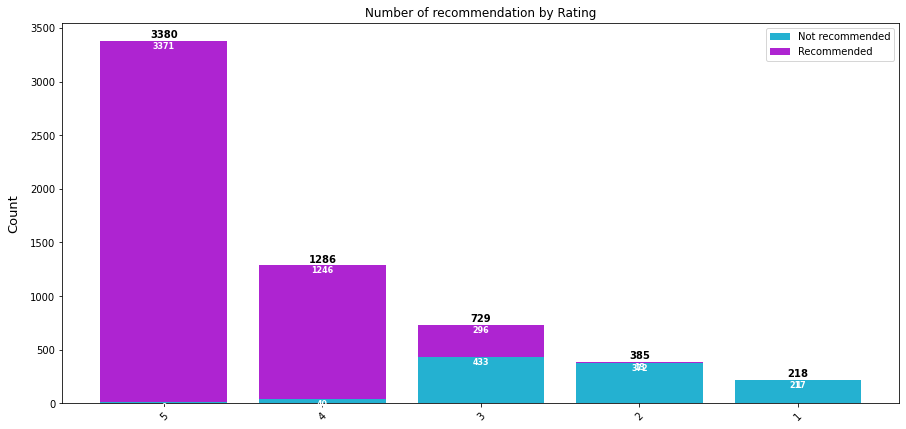

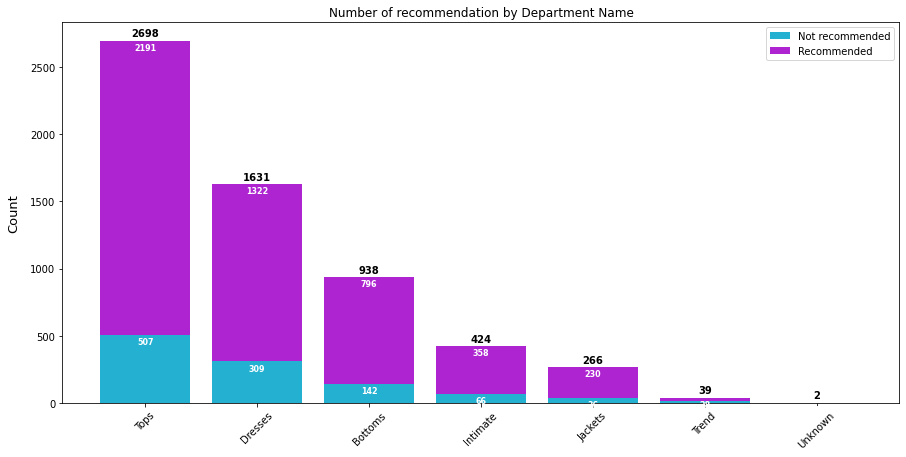

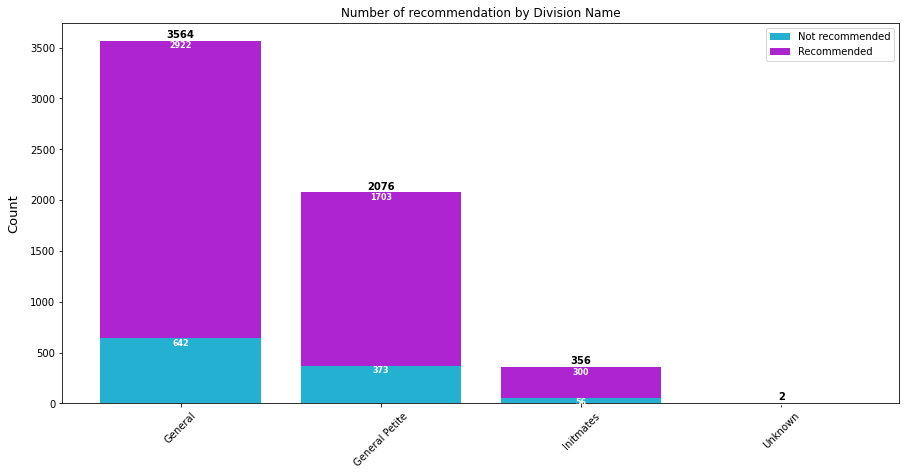

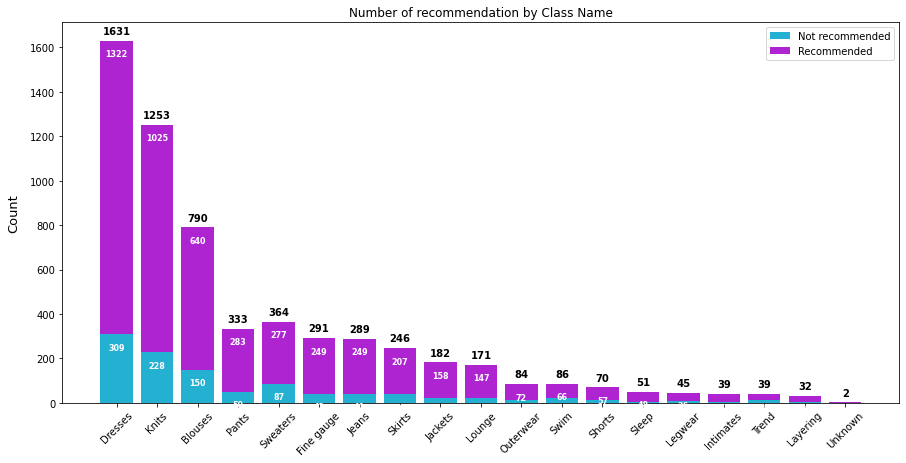

In [19]:
from pyspark.sql.functions import col

feature_lst=['Rating','Department Name','Division Name','Class Name']
for idx,feature in enumerate(feature_lst):
  sdf=nodup_sdf.crosstab(feature,'Recommended IND').withColumnRenamed(feature+"_Recommended IND",feature).withColumnRenamed("0","Not recommended").withColumnRenamed("1","Recommended")
  psdf=sdf.pandas_api() 
  psdf.replace({feature: {'null': 'Unknown'}},inplace=True)
  print('\n\n',start+'---------Number of recommendations by '+feature+end,'---------\n')
  psdf.sort_values(["Recommended", "Not recommended"], ascending=(False, False),inplace=True)
  print(psdf.to_string(index=False)) # To not print index column 

  # Convert to pandas dataframe to use seaborn
  pdf=psdf.to_pandas()
  pdf.set_index(feature,inplace=True)

  # https://www.pythoncharts.com/matplotlib/stacked-bar-charts-labels/
  import seaborn as sns

  fig, ax = plt.subplots(figsize=(15, 7))
  plt.ylabel('Count', size=13, labelpad=10)
  plt.xticks(rotation=45)
  colors = ['#24b1d1', '#ae24d1']
  bottom = np.zeros(len(pdf))

  for i, col in enumerate(pdf.columns):
    ax.bar(pdf.index, pdf[col], bottom=bottom, label=col, color=colors[i])
    bottom += np.array(pdf[col])
  
  totals = pdf.sum(axis=1)
  y_offset=30
  for i, total in enumerate(totals):
    ax.text(totals.index[i],total+y_offset, int(total), ha='center', weight='bold')
  
  # Put the annotations inside the bars themselves by using a negative offset.
  y_offset=-70
  # For each patch (basically each rectangle within the bar), add a label.
  for bar in ax.patches:
    ax.text(
        # Put the text in the middle of each bar. get_x returns the start
        # so we add half the width to get to the middle.
        bar.get_x()+bar.get_width()/2,
        # Vertically, add the height of the bar to the start of the bar,
        # along with the offset.
        bar.get_height()+bar.get_y()+y_offset,
        # This is actual value we'll show.
        int(bar.get_height()),
        # Center the labels and style them a bit.
        ha='center',
        color='w',
        weight='bold',
        size=8
    )
    
  ax.set_title('Number of recommendation by '+feature)
  ax.legend()

  del sdf,psdf,pdf

<Figure size 1080x1080 with 0 Axes>

(0.0, 1.0, 0.0, 1.0)

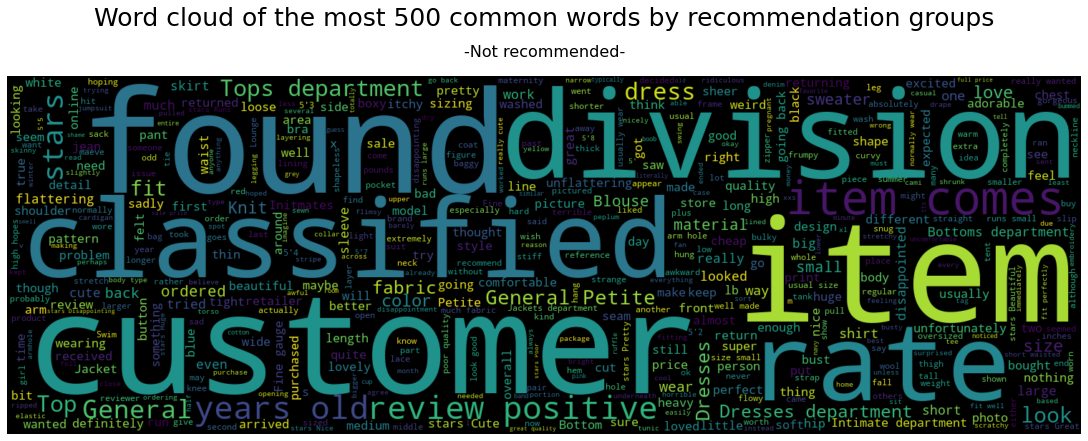

<Figure size 1080x1080 with 0 Axes>

(0.0, 1.0, 0.0, 1.0)

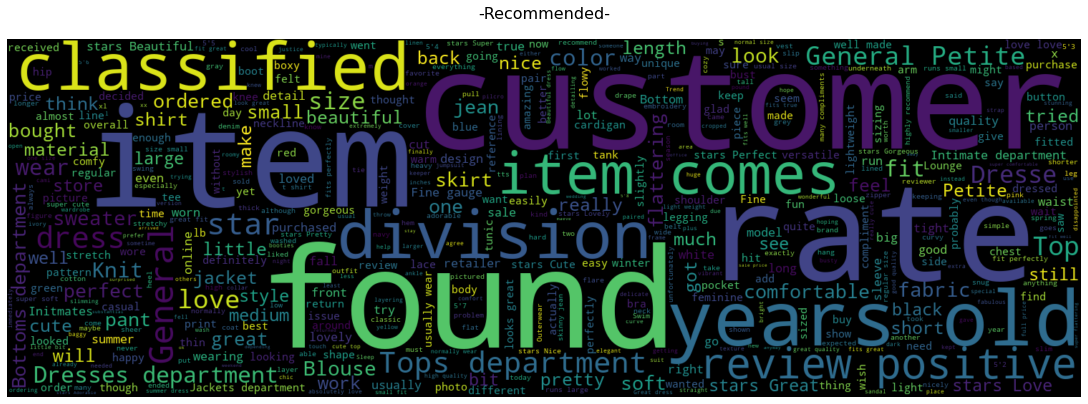

In [20]:
from pyspark.sql import functions as F
from wordcloud import WordCloud

cond_lst=final_sdf.select(F.collect_set('Recommended IND').alias('Recommended IND')).first()['Recommended IND']
title_lst=['Not recommended' if x==0 else 'Recommended' for x in cond_lst]

for idx,cond in enumerate(cond_lst):
  lst=final_sdf.filter(final_sdf['Recommended IND']==cond).select('text').rdd.flatMap(lambda x: x).collect()
  fullStr=' '.join(lst)
  wordcloud=WordCloud(max_words=500,width=1500,height=500).generate(fullStr)
  # Display the generated image:
  plt.figure(figsize=(15,15),constrained_layout=True)
  plt.axis("off")
  plt.imshow(wordcloud,interpolation='bilinear')
  title=plt.title('-'+title_lst[cond]+'-',fontsize=16,pad=20)
  if idx==0:
    suptitle=plt.suptitle('Word cloud of the most 500 common words by recommendation groups',x=0.5,y=0.73,fontsize=25)
  plt.show();

### **Features preprocessing with Spark NLP <sup>[2](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Public/2.Text_Preprocessing_with_SparkNLP_Annotators_Transformers.ipynb)</sup>**
- Combination of both numerical and textual features into one single text input feature

In [21]:
%%time

documentAssembler = DocumentAssembler()\
                   .setInputCol("text")\
                   .setOutputCol("document")

tokenizer = Tokenizer() \
            .setInputCols(["document"]) \
            .setOutputCol("token")

# Removes all dirty characters from text following a regex pattern and transforms words based on a provided dictionary
normalizer = Normalizer() \
            .setInputCols(["token"]) \
            .setOutputCol("normalized")\
            .setLowercase(True)\
            .setCleanupPatterns(["[^\w\d\s]"]) # remove punctuations (keep alphanumeric chars)
                                               # if we don't set CleanupPatterns, it will only keep alphabet letters ([^A-Za-z])

# This annotator excludes from a sequence of strings (e.g. the output of a Tokenizer, Normalizer, Lemmatizer, and Stemmer) and drops all the stop words from the input sequences.
stopwords_cleaner = StopWordsCleaner()\
                   .setInputCols("normalized")\
                   .setOutputCol("cleanTokens")\
                   .setCaseSensitive(False)

# Returns hard-stems out of words with the objective of retrieving the meaningful part of the words
stemmer = Stemmer() \
          .setInputCols(["cleanTokens"]) \
          .setOutputCol("stem")

finisher = Finisher() \
          .setInputCols(["stem"]) \
          .setOutputCols(["token_features"]) \
          .setOutputAsArray(True) \
          .setCleanAnnotations(False)

nlp_pipeline = Pipeline(stages=[documentAssembler
                              ,tokenizer
                              ,normalizer
                              ,stopwords_cleaner
                              ,stemmer
                              ,finisher
                              ])

nlp_model = nlp_pipeline.fit(final_sdf)
processed0 = nlp_model.transform(final_sdf)
processed0.count()
print(start+'Spark dataframe after text pre-processing:'+end,'\n')
processed0.show(4,truncate=30)

Spark dataframe after text pre-processing: 

+---+-----------------+------------------------------+------+---------------+-----------------------+--------------+---------------+----------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+
|Age|            Title|                   Review Text|Rating|Recommended IND|Positive Feedback Count| Division Name|Department Name|Class Name|                          text|                      document|                         token|                    normalized|                   cleanTokens|                          stem|                token_features|
+---+-----------------+------------------------------+------+---------------+-----------------------+--------------+---------------+----------+------------------------------+------------------------------+----------------------------

In [22]:
print(start+'The stop words are:'+end,'\n')
stopwords_cleaner.getStopWords()

The stop words are: 



['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'no',
 'nor',
 '

In [23]:
# Import the necessary class
from pyspark.ml.feature import VectorAssembler
# Create an assembler object for numerical features only
vectorAssembler=VectorAssembler(inputCols=['Age','Rating','Positive Feedback Count'],outputCol='numericalFeatures')

# Consolidate feature columns
processed1=vectorAssembler.transform(processed0)

print(start+'Spark dataframe after final consolidation of numerical features:'+end,'\n')
processed1.show(5,truncate=30)

Spark dataframe after final consolidation of numerical features: 

+---+--------------------------+------------------------------+------+---------------+-----------------------+--------------+---------------+----------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+-----------------+
|Age|                     Title|                   Review Text|Rating|Recommended IND|Positive Feedback Count| Division Name|Department Name|Class Name|                          text|                      document|                         token|                    normalized|                   cleanTokens|                          stem|                token_features|numericalFeatures|
+---+--------------------------+------------------------------+------+---------------+-----------------------+--------------+---------------+----------+-----

<Figure size 1080x1080 with 0 Axes>

(0.0, 1.0, 0.0, 1.0)

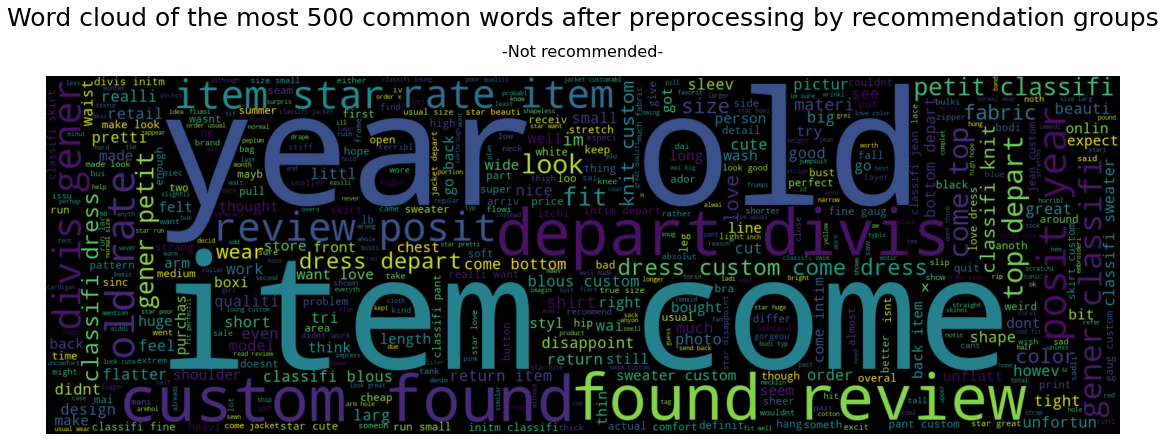

<Figure size 1080x1080 with 0 Axes>

(0.0, 1.0, 0.0, 1.0)

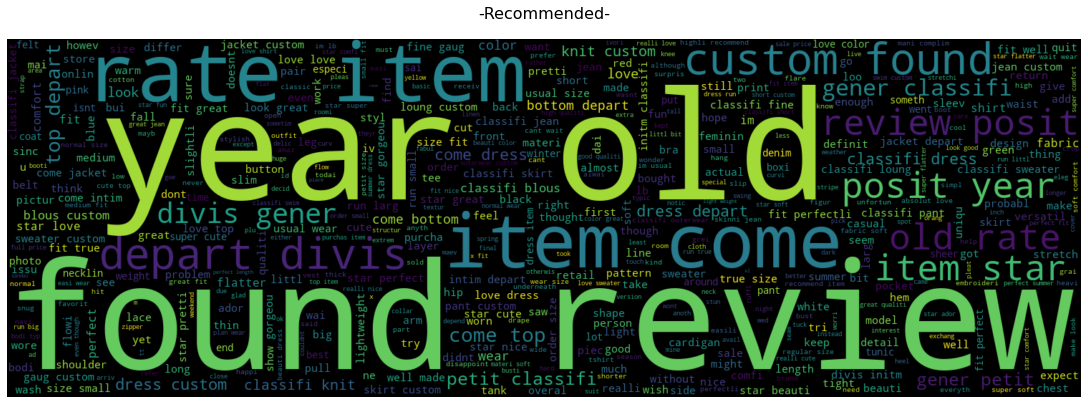

In [24]:
# https://sparkbyexamples.com/pyspark/pyspark-convert-array-column-to-string-column/
from pyspark.sql.functions import col, concat_ws
sdf = processed1.withColumn("token_features",concat_ws(",",col("token_features"))).withColumn("token_features",regexp_replace("token_features", ",", " "))

from pyspark.sql import functions as F
from wordcloud import WordCloud

cond_lst=sdf.select(F.collect_set('Recommended IND').alias('Recommended IND')).first()['Recommended IND']
title_lst=['Not recommended' if x==0 else 'Recommended' for x in cond_lst]

for idx,cond in enumerate(cond_lst):
  lst=sdf.filter(sdf['Recommended IND']==cond).select('token_features').rdd.flatMap(lambda x: x).collect()
  fullStr=' '.join(lst)
  wordcloud=WordCloud(max_words=500,width=1500,height=500).generate(fullStr)
  # Display the generated image:
  plt.figure(figsize=(15,15),constrained_layout=True)
  plt.axis("off")
  plt.imshow(wordcloud,interpolation='bilinear')
  title=plt.title('-'+title_lst[cond]+'-',fontsize=16,pad=20)
  if idx==0:
    suptitle=plt.suptitle('Word cloud of the most 500 common words after preprocessing by recommendation groups',x=0.5,y=0.73,fontsize=25)

  plt.show();

### **Train, test split**

*   Compute and consolidate class weights due to class imbalance

In [25]:
# Train test split, 80% train, 20% test
# Set seed for reproducibility
(train, test) = processed1.randomSplit([0.8, 0.2], seed = 42)
print(start+"Training Dataset Count: "+end, str(train.count()))
print(start+"Test Dataset Count: "+end, str(test.count()))

Training Dataset Count:  4846
Test Dataset Count:  1152


In [26]:
# https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html
# Estimate class weights for unbalanced datasets
weight0=train.count()/((train.select('Recommended IND').distinct().count())*(train.filter(train["Recommended IND"] == 0).count()))
weight1=train.count()/((train.select('Recommended IND').distinct().count())*(train.filter(train["Recommended IND"] == 1).count()))

print(start+"Class weights:"+end
      ,'\nNot recommended = '+str(weight0)
      ,'\nRecommended     = '+str(weight1)
      ,'\n')

# Assign class weight to respective class in the dataframe 
train=train.withColumn('weightCol',
                       func.when(func.col('Recommended IND')==0, weight0)
                       .otherwise(weight1)
                       )

print(start+"Training set:"+end)
train.show(5,truncate=30)

# Keep only the required columns for NLP model training
train_nlp=train.select('Recommended IND','weightCol','token_features')

print(start+"Training set (three columns only) specifically for NLP training:"+end)
train_nlp.show(5,truncate=30)

# Keep only the columns for numerical data modellig
train_numeric=train.select('Recommended IND','weightCol','numericalFeatures')

# Keep only the text and target columns for pre-trained DL 
train_txt=train.select('Recommended IND','weightCol','text')

print(start+"Summary statistics of class weights:"+end,'\n')

# Check: Mean of weightCol should be 1 and sum should be equal to number of counts
(train.agg(func.count('weightCol').alias('count'),
           func.sum('weightCol').alias('sum'),
           func.mean('weightCol').alias('mean'),
           func.stddev('weightCol').alias('std'),
           func.min('weightCol').alias('min'),
           func.max('weightCol').alias('max'))).show()

# Check sum of weightCol=total counts of training set
(train.groupby("Recommended IND").agg(func.count('weightCol').alias('count'),
                                      func.sum('weightCol').alias('sum'),
                                      func.mean('weightCol').alias('mean'),
                                      func.stddev('weightCol').alias('std'),
                                      func.min('weightCol').alias('min'),
                                      func.max('weightCol').alias('max'))).show()

Class weights: 
Not recommended = 2.8076477404403244 
Recommended     = 0.6083354255586242 

Training set:
+---+----------------+------------------------------+------+---------------+-----------------------+--------------+---------------+----------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+-----------------+------------------+
|Age|           Title|                   Review Text|Rating|Recommended IND|Positive Feedback Count| Division Name|Department Name|Class Name|                          text|                      document|                         token|                    normalized|                   cleanTokens|                          stem|                token_features|numericalFeatures|         weightCol|
+---+----------------+------------------------------+------+---------------+-----------------------

### **Save train, test set in Google Drive**

#### **Mount to Google Drive**

In [27]:
# Mount to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### **Save to Google Drive**
*   Ensure same training and test set use for all training models

In [28]:
# Save train and test set as parquet functionality in Google drive for later model training
# https://sparkbyexamples.com/pyspark/pyspark-read-and-write-parquet-file/
train.write.parquet("/content/drive/MyDrive/Colab Notebooks/train.parquet")
train_nlp.write.parquet("/content/drive/MyDrive/Colab Notebooks/train_nlp.parquet")
train_txt.write.parquet("/content/drive/MyDrive/Colab Notebooks/train_txt.parquet")
train_numeric.write.parquet("/content/drive/MyDrive/Colab Notebooks/train_numeric.parquet")
test.write.parquet("/content/drive/MyDrive/Colab Notebooks/test.parquet")

#### **To load**
*   For checking


In [29]:
# To load
train = spark.read.parquet('/content/drive/MyDrive/Colab Notebooks/train.parquet')
train_nlp = spark.read.parquet('/content/drive/MyDrive/Colab Notebooks/train_nlp.parquet')
train_txt = spark.read.parquet('/content/drive/MyDrive/Colab Notebooks/train_txt.parquet')
train_numeric = spark.read.parquet('/content/drive/MyDrive/Colab Notebooks/train_numeric.parquet')
test = spark.read.parquet('/content/drive/MyDrive/Colab Notebooks/test.parquet')

In [30]:
print(start+"---- Check after loading from Google Drive ----\n"+end)
train.show(3,truncate=30)
train_nlp.show(3,truncate=30)
train_txt.show(3,truncate=30)
train_numeric.show(3,truncate=30)
test.show(3,truncate=30)

print(start+"Training Dataset Count: "+end, str(train.count()))
print(start+"Test Dataset Count: "+end, str(test.count()))

print()

# Check: Mean of weightCol should be 1 and sum should be equal to number of counts
(train.agg(F.count('weightCol').alias('count'),
           F.sum('weightCol').alias('sum'),
           F.mean('weightCol').alias('mean'),
           F.stddev('weightCol').alias('std'),
           F.min('weightCol').alias('min'),
           F.max('weightCol').alias('max'))).show()

# Check sum of weightCol=total counts of training set
(train.groupby("Recommended IND").agg(F.count('weightCol').alias('count'),
                                      F.sum('weightCol').alias('sum'),
                                      F.mean('weightCol').alias('mean'),
                                      F.stddev('weightCol').alias('std'),
                                      F.min('weightCol').alias('min'),
                                      F.max('weightCol').alias('max'))).show()

---- Check after loading from Google Drive ----

+---+--------+------------------------------+------+---------------+-----------------------+--------------+---------------+----------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+-----------------+------------------+
|Age|   Title|                   Review Text|Rating|Recommended IND|Positive Feedback Count| Division Name|Department Name|Class Name|                          text|                      document|                         token|                    normalized|                   cleanTokens|                          stem|                token_features|numericalFeatures|         weightCol|
+---+--------+------------------------------+------+---------------+-----------------------+--------------+---------------+----------+------------------------------+--------

In [31]:
spark.stop()